In [1]:
import hashlib
import time
import math
import matplotlib.pyplot as plt
from random import SystemRandom, randint

"""
generate a number of length
"""


def generate_number(k):
    random = SystemRandom()
    p = random.getrandbits(k)
    binary = bin(p)
    new_binary = binary[0:len(binary) - 1] + "1"
    return int(new_binary, 2)

def generate_prime_number_below_bits(x):
    prime = int(''.join(map(str,[randint(0,1) for _ in range(x)])),2)
    while not check_prime(prime):
        prime = int(''.join(map(str,[randint(0,1) for _ in range(x)])),2)

    return prime

"""
Performs Miller Rabin Test
Input : n = number, r
"""


def miller_rabin_test(r, n):
    a = 2 + randint(2, n - 2)

    p = pow(a, r, n)

    if p == 1 or p == n - 1:
        return True

    while r != (n - 1):

        p = pow(p, 2, n)
        r *= 2

        if p == 1:
            return False

        if p == (n - 1):
            return True

    return False


"""
performs  prime check
Input : n = number which has to be checked
Output : true or false
"""

def check_prime(n):
    if n == 2 or n == 3:
        return True

    elif n <= 1 or n % 2 == 0:
        return False

    r = n - 1

    while r % 2 == 0:
        r //= 2

    for i in range(128):
        if not miller_rabin_test(r, n):
            return False

    return True


"""
generate a prime number
"""

def give_prime(k):
    prime = generate_number(k)

    while not check_prime(prime):
        prime = generate_number(k)

    return prime

def give_parameters():
    return (SystemRandom().randint(0,100), SystemRandom().randint(1,100), give_prime())

# Fast Modular Power Calculation

In [2]:
def power(x, a, N) :
    res = 1     # Initialize result
 
    # Update x if it is more
    # than or equal to p
    x = x % N
     
    if (x == 0) :
        return 0
 
    while (a > 0) :
         
        # If y is odd, multiply
        # x with result
        if ((a & 1) == 1) :
            res = (res * x) % N
 
        # y must be even now
        a = a >> 1      # y = y/2
        x = (x * x) % N
         
    return res

# VDF Setup -- the basic parameter (N, x) will be the same all VDF scheme

### N -- Module
### x -- sample instance

In [3]:
def Setup(Lambda, j):
#     start_1 = time.time()
#     start_2 = time.time()
#     start_3 = time.time()
    
    p = give_prime(Lambda);
    q = give_prime(Lambda);
    x = generate_number(Lambda)
    
    start_1 = time.time()
    start_2 = time.time()
    start_3 = time.time()
    N = p * q
    phiN = (p-1)*(q-1)
    
    T = 2**j
    end_3 = time.time()
    
    t = (2**T) % phiN
    
    ybar = power(x, t, N)
    
    Gamma = hashlib.sha512(str(ybar).encode())
    end_2 = time.time()
    
    Tcap = SystemRandom().randint(1,T)
    xcap = power(x, Tcap, N)
    end_1 = time.time()
    
    st_1 = round((end_1-start_1) * 1000, 5)  # For Proposed VDF - 1
    st_2 = round((end_2-start_2) * 1000, 5)  # For Proposed VDF - 2
    st_3 = round((end_3-start_3) * 1000, 5)  # For Wesoloski and Pietrzak VDF
    
    return (N, x, xcap, T, Tcap, Gamma, st_1, st_2, st_3)

## Wesoloski's VDF (Efficient VDF)

In [4]:
def Wes_Eval(Lambda, N, x, T):

    start = time.time()
    y = power(x, 2**T, N)
    end = time.time()
    et = round((end-start) * 1000, 2)
#     print("\nEvaluation Time:", {et})
    
   
    start = time.time()
    l = give_prime(2*Lambda)
    q = (2**T)//l
    
    pi = power(x, q, N)
    end = time.time()
    pt = round((end-start) * 1000, 5)
#     print("Proof Generation Time:", {pt})

    
    return y, pi, l, et, pt

In [5]:
def Wes_Verify(Lambda, N, x, T, y, pi, l):

    start = time.time()
    r = 2**T % l
    
    ycap = (power(pi, l, N) * power(x, r, N)) % N
    end = time.time()
    vt = round((end-start) * 1000, 5)
#     print("\nVerification Time:", {vt})
    
    if(y == ycap):
        return 1, vt
    return 0, vt

In [6]:
def Wes_Main(Lambda, N, x, T):
    y, pi, l, et, pt = Wes_Eval(Lambda, N, x, T)
    
    out, vt = Wes_Verify(Lambda, N, x, T, y, pi, l)
    if(out==1):
        print("\nAccept")
    else:
        print("\nReject")
        
    return et, pt, vt

## Pietrzak's VDF (Simple VDF)

In [7]:
def Pie_Eval(Lambda, N, x, T):

    start = time.time()
    y = power(x, 2**T, N)
    end = time.time()
    et = round((end-start) * 1000, 2)
#     print("\nEvaluation Time:", {et})
    
    start = time.time()
    xprime = x
    yprime = y
    pi = []
    r = []
    for i in range(1, round(math.log2(T))+1):
        pi.append(pow(xprime, (2**int(T/(2**i))), N))
        r.append(give_prime(Lambda//2))
        xprime = (pow(xprime, r[i-1], N) * pi[i-1]) % N
        yprime = (pow(pi[i-1], r[i-1], N) * yprime) % N
    end = time.time()
    pt = round((end-start) * 1000, 5)
#     print("Proof Generation Time:", {pt})
    return y, pi, r, et, pt

In [8]:
def Pie_Verify(Lambda, N, x, T, y, pi, r):
    start = time.time()
    xprime = x
    yprime = y
    for i in range(1, round(math.log2(T))+1):
        xprime = (pow(xprime, r[i-1], N) * pi[i-1]) % N
        yprime = (pow(pi[i-1], r[i-1], N) * yprime) % N  
    end = time.time()
    vt = round((end-start) * 1000, 5)
#     print("\nVerification Time:", {vt})
    
    if(yprime == ((xprime*xprime) % N)):
        return 1, vt
    return 0, vt

In [9]:
def Pie_Main(Lambda, N, x, T):
    y, pi, r, et, pt = Pie_Eval(Lambda, N, x, T)
    
    out, vt = Pie_Verify(Lambda, N, x, T, y, pi, r)
    if(out==1):
        print("\nAccept")
    else:
        print("\nReject")
        
    return et, pt, vt

## The proposed VDF Scheme -- 1

In [10]:
def DH_Eval_1(Lambda, N, x, xcap, T):

    start = time.time()
    y = power(x, 2**T, N)
    end = time.time()
    et = round((end-start) * 1000, 5)
#     print("\nEvaluation Time:", {et})
    
    pi = power(xcap, 2**T, N)
    
    return y, pi, et

In [11]:
def DH_Verify_1(Lambda, N, x, xcap, T, Tcap, y, pi):

    start = time.time()
    ycap = power(y, Tcap, N)
    end = time.time()
    vt = round((end-start) * 1000, 5)
#     print("\nVerification Time:", {vt})
    
    if(ycap == pi):
        return 1, vt
    return 0, vt

In [12]:
def DH_Main_1(Lambda, N, x, xcap, T, Tcap):
    y, pi, et = DH_Eval_1(Lambda, N, x, xcap, T)
    
    out, vt = DH_Verify_1(Lambda, N, x, xcap, T, Tcap, y, pi)
    if(out==1):
        print("\nAccept")
    else:
        print("\nReject")
    return et, vt

## The proposed VDF Scheme -- 2 (Optmized version of the Scheme - 1)

In [13]:
def DH_Eval_2(Lambda, N, x, T):
    start = time.time()
    y = power(x, 2**T, N)
    end = time.time()
    et = round((end-start) * 1000, 5)
#     print("\nEvaluation Time:", {et})
    return y, et

In [14]:
def DH_Verify_2(y, Gamma):
    
    start = time.time()
    GammaCap = hashlib.sha512(str(y).encode())
    end = time.time()
    vt = round((end-start) * 1000, 5)
#     print("\nVerification Time:", {vt})    
    
    if(GammaCap.hexdigest() == Gamma.hexdigest()):
        return 1, vt
    return 0, vt

In [15]:
def DH_Main_2(Lambda, N, x, T, Gamma):
    y, et = DH_Eval_2(Lambda, N, x, T)
    
    out, vt = DH_Verify_2(y, Gamma)
    if(out==1):
        print("\nAccept")
    else:
        print("\nReject")
    return et, vt

# Graph Plots

## Setup Time

In [16]:
def Setup_Time_Plot(Time, dhvdf_1_st, dhvdf_2_st, wesvdf_st, pievdf_st):
    for i in range(len(dhvdf_1_st)):
        # plotting the points of Proposed VDF-1 
        plt.plot(Time, dhvdf_1_st[i], label = "Proposed VDF-1", color='green', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='green', markersize=12)


        # plotting the points of Proposed VDF-2
        plt.plot(Time, dhvdf_2_st[i], label = "Proposed VDF-2", color='blue', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='blue', markersize=12)


        # plotting the points of Proposed Wesoloski's VDF
        plt.plot(Time, wesvdf_st[i], label = "Wesoloski VDF", color='orange', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='orange', markersize=12)

        # plotting the points of Proposed Pietrzak's VDF
        plt.plot(Time, pievdf_st[i], label = "Pietrzak VDF", color='red', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='red', markersize=12)
        
        
        # setting x and y axis range
        # plt.ylim(1,10)
        # plt.xlim(10, 15)
 
        # naming the x axis
        plt.xlabel('Number of Exponentiations (log scale)')
        # naming the y axis
        plt.ylabel('Time (s x 1000) ')
 
        # giving a title to my graph
        plt.title('VDF Setup Time')

        # show a legend on the plot
        plt.legend()
 
        # function to show the plot
        plt.show()

## Evaluation Time

In [17]:
def Eval_Time_Plot(Time, dhvdf_1_et, dhvdf_2_et, wesvdf_et, pievdf_et):
    for i in range(len(dhvdf_1_et)):
        # plotting the points of Proposed VDF-1 
        plt.plot(Time, dhvdf_1_et[i], label = "Proposed VDF-1", color='green', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='green', markersize=12)


        # plotting the points of Proposed VDF-2
        plt.plot(Time, dhvdf_2_et[i], label = "Proposed VDF-2", color='blue', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='blue', markersize=12)


        # plotting the points of Proposed Wesoloski's VDF
        plt.plot(Time, wesvdf_et[i], label = "Wesoloski VDF", color='orange', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='orange', markersize=12)

        # plotting the points of Proposed Pietrzak's VDF
        plt.plot(Time, pievdf_et[i], label = "Pietrzak VDF", color='red', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='red', markersize=12)
        
        
        # setting x and y axis range
        # plt.ylim(1,10)
        # plt.xlim(10, 15)
 
        # naming the x axis
        plt.xlabel('Number of Exponentiations (log scale)')
        # naming the y axis
        plt.ylabel('Time (s x 1000) ')
 
        # giving a title to my graph
        plt.title('VDF Evaluation Time')

        # show a legend on the plot
        plt.legend()
 
        # function to show the plot
        plt.show()

## Proof Generation Time

In [18]:
def Proof_Time_Plot(Time, dhvdf_1_pt, dhvdf_2_pt, wesvdf_pt, pievdf_pt):
    for i in range(len(dhvdf_1_pt)):
        # plotting the points of Proposed VDF-1 
        plt.plot(Time, dhvdf_1_pt[i], label = "Proposed VDF-1", color='green', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='green', markersize=12)


        # plotting the points of Proposed VDF-2
        plt.plot(Time, dhvdf_2_pt[i], label = "Proposed VDF-2", color='blue', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='blue', markersize=12)


        # plotting the points of Proposed Wesoloski's VDF
        plt.plot(Time, wesvdf_pt[i], label = "Wesoloski VDF", color='orange', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='orange', markersize=12)

        # plotting the points of Proposed Pietrzak's VDF
        plt.plot(Time, pievdf_pt[i], label = "Pietrzak VDF", color='red', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='red', markersize=12)
        
        
        # setting x and y axis range
        # plt.ylim(1,10)
        # plt.xlim(10, 15)
 
        # naming the x axis
        plt.xlabel('Number of Exponentiations (log scale)')
        # naming the y axis
        plt.ylabel('Time (s x 1000) ')
 
        # giving a title to my graph
        plt.title('VDF Proof Generation Time')

        # show a legend on the plot
        plt.legend()
 
        # function to show the plot
        plt.show()

## Verification Time

In [19]:
def Verification_Time_Plot(Time, dhvdf_1_vt, dhvdf_2_vt, wesvdf_vt, pievdf_vt):
    for i in range(len(dhvdf_1_vt)):
        # plotting the points of Proposed VDF-1 
        plt.plot(Time, dhvdf_1_vt[i], label = "Proposed VDF-1", color='green', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='green', markersize=12)


        # plotting the points of Proposed VDF-2
        plt.plot(Time, dhvdf_2_vt[i], label = "Proposed VDF-2", color='blue', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='blue', markersize=12)


        # plotting the points of Proposed Wesoloski's VDF
        plt.plot(Time, wesvdf_vt[i], label = "Wesoloski VDF", color='orange', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='orange', markersize=12)

        # plotting the points of Proposed Pietrzak's VDF
        plt.plot(Time, pievdf_vt[i], label = "Pietrzak VDF", color='red', linestyle='solid', linewidth = 1, 
         marker='.', markerfacecolor='red', markersize=12)
        
        
        # setting x and y axis range
        # plt.ylim(1,10)
        # plt.xlim(10, 15)
 
        # naming the x axis
        plt.xlabel('Number of Exponentiations (log scale)')
        # naming the y axis
        plt.ylabel('Time (s x 1000) ')
 
        # giving a title to my graph
        plt.title('VDF Verification Time')

        # show a legend on the plot
        plt.legend()
 
        # function to show the plot
        plt.show()

# Main Function


Round -->  5 14

 ------- Efficient and Tight Verifiable Delay Function -- 1 -------


Accept

 ------- Efficient and Tight Verifiable Delay Function -- 2 -------


Accept

 ------- Wesoloski's Verifiable Delay Function (Efficient VDF) -------


Accept

 ------- Pietrzak's Verifiable Delay Function (Simple VDF) -------


Accept

Round -->  5 15

 ------- Efficient and Tight Verifiable Delay Function -- 1 -------


Accept

 ------- Efficient and Tight Verifiable Delay Function -- 2 -------


Accept

 ------- Wesoloski's Verifiable Delay Function (Efficient VDF) -------


Accept

 ------- Pietrzak's Verifiable Delay Function (Simple VDF) -------


Accept

Round -->  5 16

 ------- Efficient and Tight Verifiable Delay Function -- 1 -------


Accept

 ------- Efficient and Tight Verifiable Delay Function -- 2 -------


Accept

 ------- Wesoloski's Verifiable Delay Function (Efficient VDF) -------


Accept

 ------- Pietrzak's Verifiable Delay Function (Simple VDF) -------


Accept

Round 

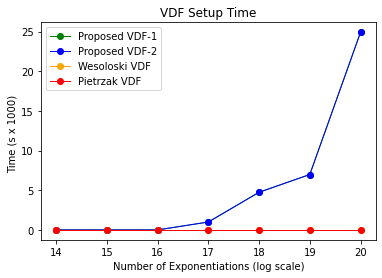


 ------- VDF Evaluation Time Graphs -------



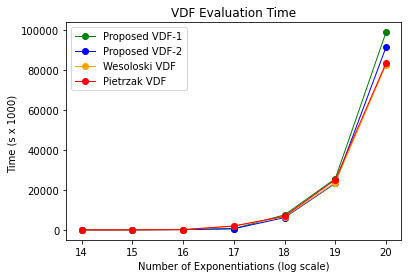


 ------- VDF Proof Generation Time Graphs -------



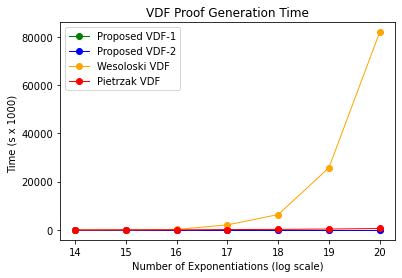


 ------- VDF Verification Time Graphs -------



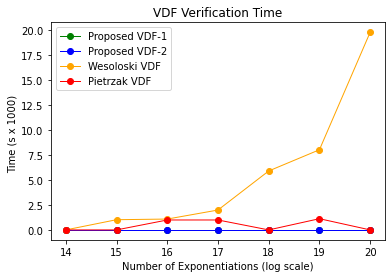

In [20]:
if __name__=="__main__":
    
    dhvdf_1_st = []
    dhvdf_1_et = []
    dhvdf_1_pt = []
    dhvdf_1_vt = []
    
    dhvdf_2_st = []
    dhvdf_2_et = []
    dhvdf_2_pt = []
    dhvdf_2_vt = []
    
    wesvdf_st = []
    wesvdf_et = []
    wesvdf_pt = []
    wesvdf_vt = []
    
    pievdf_st = []
    pievdf_et = []
    pievdf_pt = []
    pievdf_vt = []
    
    for i in range(5, 6): # Lambda = 512, 1024, 2048
        Lambda = 2**i
        
        dhvdf1st = []
        dhvdf1et = []
        dhvdf1pt = []
        dhvdf1vt = []
        
        dhvdf2st = []
        dhvdf2et = []
        dhvdf2pt = []
        dhvdf2vt = []
        
        wesvdfst = []
        wesvdfet = []
        wesvdfpt = []
        wesvdfvt = []
            
        pievdfst = []
        pievdfet = []
        pievdfpt = []
        pievdfvt = []
        
        Time = []
        for j in range (14, 21): # T = 2^14, 2^15, 2^16, 2^17, 2^18, 2^19, 2^20
            N, x, xcap, T, Tcap, Gamma, st_1, st_2, st_3 = Setup(Lambda, j)
        
#             print("The value of N:", N)
#             print("The Value of x:", x)
#             print("The Value of xcap:", xcap)
#             print("The Value of T:", T)
            
            Time.append(j)
    
            print("\nRound --> ", i, j)
            
            print("\n ------- Efficient and Tight Verifiable Delay Function -- 1 -------\n")
            et, vt = DH_Main_1(Lambda, N, x, xcap, T, Tcap)
            dhvdf1st.append(st_1)
            dhvdf1et.append(et)
            dhvdf1pt.append(0)
            dhvdf1vt.append(vt)
            
    
            print("\n ------- Efficient and Tight Verifiable Delay Function -- 2 -------\n")
            et, vt = DH_Main_2(Lambda, N, x, T, Gamma)
            dhvdf2st.append(st_2)
            dhvdf2et.append(et)
            dhvdf2pt.append(0)
            dhvdf2vt.append(vt)
            
    
            print("\n ------- Wesoloski's Verifiable Delay Function (Efficient VDF) -------\n")
            et, pt, vt = Wes_Main(Lambda, N, x, T)     
            wesvdfst.append(st_3)
            wesvdfet.append(et)
            wesvdfpt.append(pt)
            wesvdfvt.append(vt)
            
    
            print("\n ------- Pietrzak's Verifiable Delay Function (Simple VDF) -------\n")
            et, pt, vt = Pie_Main(Lambda, N, x, T)    
            pievdfst.append(st_3)
            pievdfet.append(et)
            pievdfpt.append(pt)
            pievdfvt.append(vt)
        
        dhvdf_1_st.append(dhvdf1st)
        dhvdf_1_et.append(dhvdf1et)
        dhvdf_1_pt.append(dhvdf1pt)
        dhvdf_1_vt.append(dhvdf1vt)
        
        dhvdf_2_st.append(dhvdf2st)
        dhvdf_2_et.append(dhvdf2et)
        dhvdf_2_pt.append(dhvdf2pt)
        dhvdf_2_vt.append(dhvdf2vt)
        
        wesvdf_st.append(wesvdfst)
        wesvdf_et.append(wesvdfet)
        wesvdf_pt.append(wesvdfpt)
        wesvdf_vt.append(wesvdfvt)
    
        pievdf_st.append(pievdfst)
        pievdf_et.append(pievdfet)
        pievdf_pt.append(pievdfpt)
        pievdf_vt.append(pievdfvt)

    print("\n ------- VDF Setup Time Graphs -------\n")
    Setup_Time_Plot(Time, dhvdf_1_st, dhvdf_2_st, wesvdf_st, pievdf_st)
    
    print("\n ------- VDF Evaluation Time Graphs -------\n")
    Eval_Time_Plot(Time, dhvdf_1_et, dhvdf_2_et, wesvdf_et, pievdf_et)
    
    print("\n ------- VDF Proof Generation Time Graphs -------\n")
    Proof_Time_Plot(Time, dhvdf_1_pt, dhvdf_2_pt, wesvdf_pt, pievdf_pt)
    
    print("\n ------- VDF Verification Time Graphs -------\n")
    Verification_Time_Plot(Time, dhvdf_1_vt, dhvdf_2_vt, wesvdf_vt, pievdf_vt)